# Tenseurs en notation indicielle


Ce notebook montre comment manipuler des tenseurs en notation indicielle avec [SageMath](https://www.sagemath.org/)

La représentation interne se fait sous la forme de graphes, à la manière des notations de Penrose. Pour une introduction à ces notations, voir par exemple :

- [Birdtracks for SU(N)](https://arxiv.org/abs/1707.07280), Une introduction pédagogique à ces notations par Stefan Keppeler, avec des applications à SU(N),
- [Group Theory](http://birdtracks.eu/), Le livre très complet de Predrag Cvitanović sur lequel est basé le précédent article,
- [A survey of graphical languages for monoidal categories](https://www.mathstat.dal.ca/~selinger/papers/graphical.pdf) Une formalisation mathématique de ces notations dans le cas général.


L'implémentation s'appuye sur [NetworkX](https://networkx.github.io/), une librairie de gestion de graphes, livrée avec sagemath (à vérifier, sinon un simple "pip install" devrait suffire).

Les autres dépendances sont :

   - ``Sagemath`` > 9.0 avec Python 3,
   - ``network2tikz`` pour l'affichage des graphes, facultatif, à installer avec "pip install network2tikz",
   - Les programmes ``pdflatex``, ``pdfcrop`` et ``pdftoppm``, appelés pour l'affichage des graphes, facultatifs.
   
Toutes les classes et fonctions sont pour l'instant définies dans le notebook ``Abstract_Tensor_Classes.ipynb``, qui initialise également quelques variables.

In [1]:
%run Abstract_Tensor_Classes.ipynb
%display latex

## Indices 

Les indices sont représentés par des variables symboliques. Certaines communément utilisée ont été définies lors de l'initialisation. Pour l'instant il s'agit de quelques lettres grecques, mais il serait intéressant d'avoir plusieurs options.

In [2]:
greek_variables

[mu, nu, rho, sigma, alpha, beta, kappa, theta, zeta, eta]

In [3]:
mu, nu

(mu, nu)

Au cas ou ces indices ne suffirait pas, d'autres sont également créés avec des suffixes numériques et sont injectés dans l'espace de noms, pour l'instant 50 par lettre grecque, (ce qui est un petit peu exagéré en général).

TODO: Faire en sorte que ces indices ne soient pas générés à l'avance. Peut-être avec une nouvelle structure qui les distribue au fur et à mesure. Il peut aussi être imaginé de ne pas utiliser des variables symboliques, mais un autre type d'objet qui puisse être coercé vers SR en cas de besoin.
    

In [4]:
extended_greek_variables[:30]

[mu,
 nu,
 rho,
 sigma,
 alpha,
 beta,
 kappa,
 theta,
 zeta,
 eta,
 mu_1,
 nu_1,
 rho_1,
 sigma_1,
 alpha_1,
 beta_1,
 kappa_1,
 theta_1,
 zeta_1,
 eta_1,
 mu_2,
 nu_2,
 rho_2,
 sigma_2,
 alpha_2,
 beta_2,
 kappa_2,
 theta_2,
 zeta_2,
 eta_2]

In [5]:
theta_48

theta_48

## Tenseurs

Les tenseurs sont représentés par des fonctions symboliques, prenant le même nombre d'argument qu'ils comportent d'indices. 

TODO: Ajouter la possibilité que ces fonctions symboliques puisse dépendre d'argument supplémentaires, par example des coordonnées, ou un point d'une variété (comment le coercer à SR ?) pour représenter un champs de tenseur.

Dans cet exemple, on définit ici un certain nombre de tenseurs "de base" :

- $g^{\mu, \nu}$, métrique de signature impaire,
- $\delta$, matrice identité de dimension 4,
- $\epsilon^{\mu \nu \rho \sigma}$, Pseudo tenseur de Levi-Civita, dans l'une des convention de signe (laquelle ???),
- $R^\mu_{\nu\rho\sigma}$, tenseur de Riemann, pas utilisé par la suite,
- $\gamma^{\mu}$, matrice gamma de l'algèbre de Clifford de dimension 4, sans préciser le choix de représentation,
- $\gamma_5$, gamma_5, dans la même représentation non-précisée,
- $p^\mu$ et $k^\mu$, deux vecteurs.

In [6]:
g = function('g', nargs=2)
delta = function('delta', nargs=2, latex_name=r'\delta')
eps = function('eps', nargs=4, latex_name=r'\epsilon')
R = function('R', nargs=4, latex_name=r'R')
dirac_gamma = function('dirac_gamma', nargs=3, latex_name=r'\gamma')
gamma5 = function('gamma_5', nargs=2, latex_name=r'\gamma_5')
p = function('p', nargs=1)
k = function('k', nargs=1)

BUG: Exécuter cette cellule plus d'une fois entraine des conséquences imprévisibles. Je pense que cela vient d'un problème dans l'interface entre SR et Maxima. Le code suivant devrait toujours retourner ``True``, mais ce n'est pas le cas si ``g`` a été redéfine une seconde fois. La fonction ``operator`` renvoie toujours la référence à la première fonction créée portant ce nom. Voir https://ask.sagemath.org/question/51964/ .

Si la cellule suivante renvoie ``False``, il faut redémarer le noyau.

In [7]:
g(mu, nu).operator() is g

True

## Contractions

On adopte ici la convention de sommation d'Einstein pour les indices répétés. Chaque contraction doit donc se faire dans un "espace" particulier. Il peut s'agir d'un espace vectoriel $V$, mais également d'objets plus abstraits. Quelques example incluent :

- L'espace de Minkowski dans la contraction $g^{\mu \nu}g_{\nu \rho}$
- Les spineurs de dirac dans le produit $\gamma^\mu\gamma^\nu$
- Les générateurs de SU(N) dans la dérivée covariante $\partial_\mu-ieT^aG^a_\mu$
- Les spins + ou - dans la relation de completude:
     $$\sum_{s=\pm} u_s(p) \bar{u}_s(p) = p_\mu\gamma^\mu +m$$

On peut bien sûr mélanger différent types d'indices dans un même tenseur, c'est le cas pour les matrices gamma par exemple.

En général les arêtes sont orientées, mais si on ne distingue pas $V$ et son dual, alors l'orientation de l'arête n'a pas d'importance. Ici, un espace de contraction est simplement définit par un tuple "(nom, dimension, identité, arêtes orienté ?)". Dans l'exemple qui suit on utilise uniquement deux espaces : l'espace de Minkowski et celui des spineurs de Dirac. On ne fera pas la distinction entre covariant/contravariant, donc l'orientation des arêtes dans l'espace de Minkowski n'a pas d'importance.

TODO: gérer correctement les indices covariants/contravariants

In [8]:
Lo = ('Lorentz', 4, g, False)
Di = ('Dirac', 4, delta, True)

Il faut ensuite spécifier à quel espace correspond chaque indice de chaque tenseur. Pour ce faire on utilise un dictionnaire ``{tenseur: [(espace 1, nombre d'indices), (espace 2, nombre d'indices), ...]}``

In [9]:
basic_tensors = {g: [(Lo, 2)], eps: [(Lo, 4)], R: [(Lo, 4)], 
                 dirac_gamma: [(Di, 2), (Lo, 1)], gamma5: [(Di, 2)], delta: [(Di, 2)],
                 p: [(Lo, 1)], k: [(Lo, 1)]}

Il est également important de préciser les symétries de chaque tenseur pour permettre des simplifications. les symétries sont spécifiées sous la forme d'une liste de tableaux d'Young. Chaque tableau doit comporter des chiffres allant de 0 au nombre d'indice total, sans qu'un chiffre n'apparaisse deux fois.

Ici un seul tableau d'Young suffit pour chaque tenseur. Parfois plus sont nécéssaire (exemple: symétrie selon les indices 0 et 1, antisymétrie selon les indices 2 et 3).

Remarque : Il est nécessaire que l'identité de chque espace de contraction soit symétrique.

TODO: Rendre ça obligatoire / Le faire automatiquement

In [10]:
sym = {g: ([[0, 1]],),
       eps: ([[0], [1], [2], [3]],),
       R: ([[0, 2], [1, 3]],),
       dirac_gamma: (),
       gamma5: (),
       delta: ([[0, 1]],),
       p: (), k: ()}

Enfin, pour les tenseur comportant des indices pour lequel l'orientation des arêtes compte, il est nécessaire de préciser lequels sont entrants, et lesquels sont sortants.

TODO: Trouver une meilleure manière de faire

In [11]:
forced_in = {dirac_gamma: [0], gamma5: [0], delta: [0]}
forced_out = {dirac_gamma: [1], gamma5: [1], delta: [1]}

## Règles de simplifications

Les règles de simplifications sont à déclarer dans un dictionnaire ``{motif: résultat}``.

Les motifs doivent être un produit, éventuellement contracté, des tenseurs de bases sans aucun préfacteur. Les indices servent de wildcard.

Ici, on déclare les règles suivantes permettant de simplifier n'importe quel tenseur de l'algèbre de Clifford en dimension 4 :

$$
\begin{align}
\epsilon_\mu^{\ \ \mu\nu\rho} &= 0\\
{\rm Tr \ } \gamma_5 &= 0\\
{\rm Tr \ } \gamma^\mu &= 0\\
{\rm Tr \ } \gamma^\mu\gamma_5 &= 0\\
{\rm Tr \ } \gamma^\mu\gamma^\nu\gamma_5 &= 0\\
{\rm Tr \ } \gamma^\mu\gamma^\nu &= g^{\mu\nu}\\
\gamma^\mu\gamma_\mu &= 4 \ {\rm Id}\\
\gamma_5\gamma_5 &= {\rm Id}\\
\gamma_5\gamma^\mu\gamma_5 &= -\gamma^\mu\\
\gamma_5\gamma^\mu\gamma^\nu\gamma_5& = \gamma^\mu\gamma^\nu\\
\gamma^\mu\gamma^\nu\gamma^\rho &= g^{\mu\nu}\gamma^\rho+g^{\nu\rho}\gamma^\mu-g^{\mu\rho}\gamma^\nu-i\epsilon^{\mu\nu\rho\sigma}\gamma_\sigma\gamma_5\\
\epsilon_{\mu\nu\rho\sigma}\epsilon_{\alpha\beta\theta\lambda} &= - g_{\mu\kappa}g_{\nu\zeta}g_{\rho\eta}g_{\sigma\iota}\delta^{\kappa\zeta\eta\iota}_{\alpha\beta\theta\lambda}
\end{align}
$$

On voit immédiatement que puisque le nombre de tenseur diminue à chaque fois, un algorithme qui applique ces règles séquentiellement termine toujours.

TODO: Faire en sorte que la première règle ne soit pas nécessaire (facile).  
TODO: Faire en sorte que la dernière règle ne soit pas nécessaire (plus difficile).  
TODO: Ajouter automatiquement les identités de Bianchi correspondant aux symmétries de chaque tenseur (attention aux boucles infinies !)  
TODO: Vérifier automatiquement que les règles ne produisent pas de boucles infinies (possiblement impossible à cause du problème de l'arrêt, mais dans certains cas c'est évident que c'est le cas, ou que ça ne l'est pas).  
TODO: Optimisation possible : permettre à l'utilisateur d'ordonner ces règles, pour tester en priorité les plus simple / celles qui évitent les embranchements.

Puisque ``g``et ``delta`` sont identités d'espaces de contraction, les règles $g^\mu_{\ \ \mu} = 4$ et $\delta_{\alpha\alpha} = 4$ sont automatiquement injectées.

In [12]:
rules = {eps(mu, mu, nu, rho): 0,
        gamma5(alpha, alpha): 0,
        dirac_gamma(alpha, alpha, mu): 0,
        dirac_gamma(alpha, beta, mu)*gamma5(beta, alpha): 0,
        dirac_gamma(alpha, beta, mu)*dirac_gamma(beta, kappa, nu)*gamma5(kappa, alpha): 0,
        dirac_gamma(alpha, beta, mu)*dirac_gamma(beta, alpha, nu): 4*g(mu, nu),
        dirac_gamma(alpha, beta, mu)*dirac_gamma(beta, sigma, mu): 4*delta(alpha, sigma),
        dirac_gamma(alpha, beta, mu)*dirac_gamma(beta, sigma, nu)*dirac_gamma(sigma, eta, rho):
                   g(mu, nu)*dirac_gamma(alpha, eta, rho)+g(nu, rho)*dirac_gamma(alpha, eta, mu)
                  -g(mu, rho)*dirac_gamma(alpha, eta, nu)
                  -I*eps(mu, nu, rho, zeta)*dirac_gamma(alpha, beta, zeta)*gamma5(beta, eta), # depends on convention
        gamma5(alpha, beta)*gamma5(beta, sigma): delta(alpha, sigma),
        gamma5(alpha, beta)*dirac_gamma(beta, sigma, mu)*gamma5(sigma, kappa): -dirac_gamma(alpha, kappa, mu),
        gamma5(alpha, beta)*dirac_gamma(beta, sigma, mu)*dirac_gamma(sigma, kappa, nu)*gamma5(kappa, theta): 
                     dirac_gamma(alpha, sigma, mu)*dirac_gamma(sigma, theta, nu)}

La dernière règle est pénible à taper (24 termes). Pour simplifier, on utilise la fonction ``sage.combinat.symmetric_group_algebra.e``, (importée ici sous le nom ``young_symmetrizer``) afin de générer toutes les permutations ansi que leur signe, soit 24 termes au total

In [13]:
ind1 = [mu_1, nu_1, rho_1, sigma_1]
ind2 = [mu_2, nu_2, rho_2, sigma_2]
EE = eps(*ind1)*eps(*ind2)
EE2 = sum(-s*product([g(ind1[i], ind2[perm[i]-1]) for i in range(4)]) for perm, s in young_symmetrizer([[1], [2], [3], [4]]))
len(EE2)

24

In [14]:
rules[EE] = EE2

## Création de tenseurs composites


Une fois tous ces objets crées, il faut les passer à la classe ``tensor_field``, qui s'ocupera ensuite de créer des tenseurs à partir d'expressions symboliques.

TODO: optimiser ``tensor_field.__init__``

In [15]:
TF = tensor_field(basic_tensors, sym, forced_in, forced_out, rules)

Les tenseurs sont crées de la manière suivante :

In [16]:
T1 = TF(g(mu, nu))

In [17]:
print(T1)

TODO: implémenter quelque chose de mieux

Si l'option ``%display latex`` est activée, le tenseur d'affichera sous la forme d'une expression symbolique

In [18]:
T1

Remarque : Si des indices muets apparaissent dans l'expression symbolique, il n'y a pas de raison qu'ils soient les même que lors de la déclaration.

In [19]:
T2 = TF(g(mu, sigma)*g(sigma, nu))
T2

On peut ajouter des tenseurs :

In [20]:
T1+T2

Si deux tenseurs n'ont aucun indices en commun, on peut obtenir le produit tensoriel en les multipliant :

In [21]:
TF(g(mu, nu))*TF(g(rho, sigma))

TODO: Vérifier que les indices sont combatibles, les contracter sinon, ou renvoyer une erreur.  
TODO: Ajouter les autres opérations usuelles: soustraction, contraction, ...

## Simplifications

Simplifier un tenseur se fait avec la méthode ``simplify``. Contrairement à ``SR`` et pour des raisons de performance, la fonction modifie le tenseur et ne renvoie rien.

In [22]:
display(T2)
T2.simplify()
T2

Une autre option pour simplifier rapidement un tenseur est de directement passer par la classe ``tensor_field`` :

In [23]:
TF.simplify(g(mu, sigma)*g(sigma, nu))

g(mu, nu)

Vérifions par exemple la formule bien connue pour la trace de 4 matrices gamma.

In [24]:
TF.simplify(dirac_gamma(alpha, beta, mu)*dirac_gamma(beta, theta, nu)*
            dirac_gamma(theta, kappa, rho)*dirac_gamma(kappa, alpha, sigma))

-4*g(nu, sigma)*g(rho, mu) + 4*g(nu, mu)*g(rho, sigma) + 4*g(nu, rho)*g(sigma, mu)

## Plot

Parfois il peut être difficile de trouver toutes les contractions dans une expression symbolique, et de distinguer les indices externes et les indices muets. Il peut alors être utile de visualiser la structure du tenseur avec la méthode ``plot``.


Cette méthode est très lente (3 secondes chez moi) puisqu'elle nécessite un appel à ``pdflatex``, qui doit être installé sur le système. De plus le module "tikz" doit être disponible. Le fichier tex est automatiquement généré par network2tikz, compilé en pdf, puis redimensionné et converti en png avant d'être affiché. Tous les fichiers temporaires sont ensuite nettoyés.

Pour plus de fluidité, l'option ``threaded=True`` peut être utilisée, ce qui permet de lancer la compilation latex dans un autre thread. Dans ce cas l'execution de la cellule sera quasi-instantané, et l'image apparaitra quelques secondes plus tard. Pour des raison qui m'échappent, sur mon système actuel le thread plante environ une fois sur 3 et le nettoyage ne se fait parfois pas. Donc "use at your own risk".

TODO: fix that

Dans la figure obtenue, chaque noeud vert correspond à un tenseur, et chaque noeud bleu à un indice non contracté. Les arêtes représentent une ou plusieurs contractions entre deux tenseurs. L'étiquette des arêtes indique quels sont les indices contractés, avec la syntaxe ``(position sur le tenseur de départ, position sur le tenseur d'arrivée)``. Chaque couleur d'arête correspond à un espace de contraction.

TODO: rendre ces couleurs déterministes

Voici l'exemple d'un tenseur composé de 6 matrices gamma. noté de cette manière, il est difficile de savoir lesquels parmi les 18 indices sont contractés.

In [25]:
expr = dirac_gamma(alpha_1, beta_1, mu)*dirac_gamma(beta_1, kappa, nu)* \
       dirac_gamma(kappa, theta, alpha)*dirac_gamma(theta, zeta, nu)* \
       dirac_gamma(zeta, eta, mu)*dirac_gamma(eta, alpha_1, beta) # 6 matrices gamma, un bazar d'indices

T = TF(expr)
T

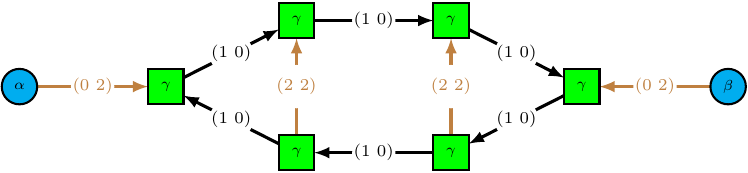

In [26]:
T.plot(size=14)

On voit ici très clairement qu'il s'agit d'un tenseur à deux indices, vivant dans l'espace de Minkowski, formé à partir d'une trace de 6 matrices gamma dont 4 ont été contractées entre elles. La simplification donne :

In [27]:
T.simplify()
T

Le positionement des noeuds est obtenu par minimisation sous contraintes d'un potentiel : harmonique si deux noeuds sont reliés par une arête (attractif ou répulsif selon la distance) et électrostatique entre toutes les paires de noeuds non reliées (répulsif). 

Si le tenseur est un produit tensoriel, le graphe comporte plusieurs composantes connexes, qui se repoussent de manière éléctrostatiques. Il est alors utile de changer la longeur cible des arêtes.

TODO: Faire ça automatiquement  
TODO: Ajouter une option (argument ``seed``) pour rendre la position de départ de la minimisation déterministe.  
TODO: Chercher un minimum global au lieu de se contenter d'un minimum local.

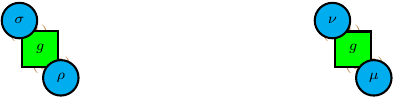

In [28]:
TF(g(mu, nu)*g(rho, sigma)).plot(size=8)

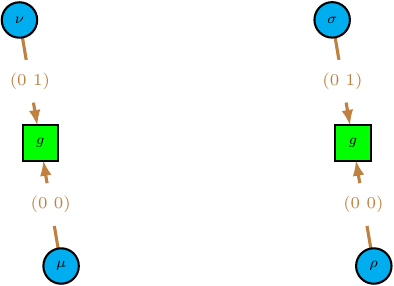

In [29]:
TF(g(mu, nu)*g(rho, sigma)).plot(size=8, edge_length=0.8)

Si le tenseur une somme d'autres tenseurs, toutes les composantes sont affichées une par une, ce qui peut prendre un certain temps.

In [30]:
T = TF(expr) # reinitialise le tenseur

In [31]:
T.simplify_step() # applique uniquement une seule étape de simplification
T

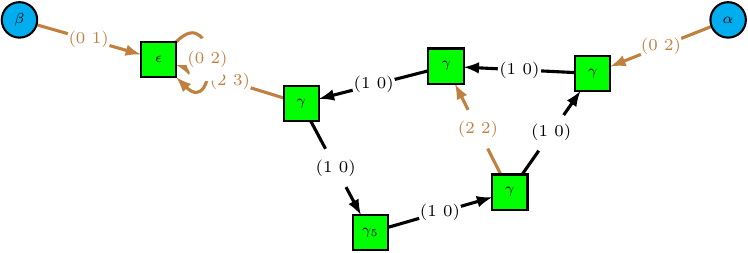

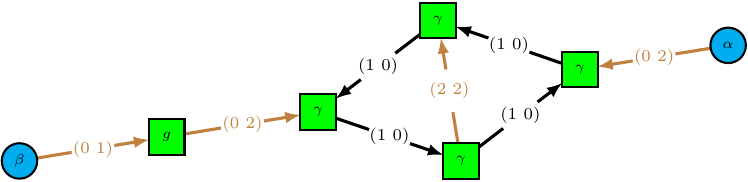

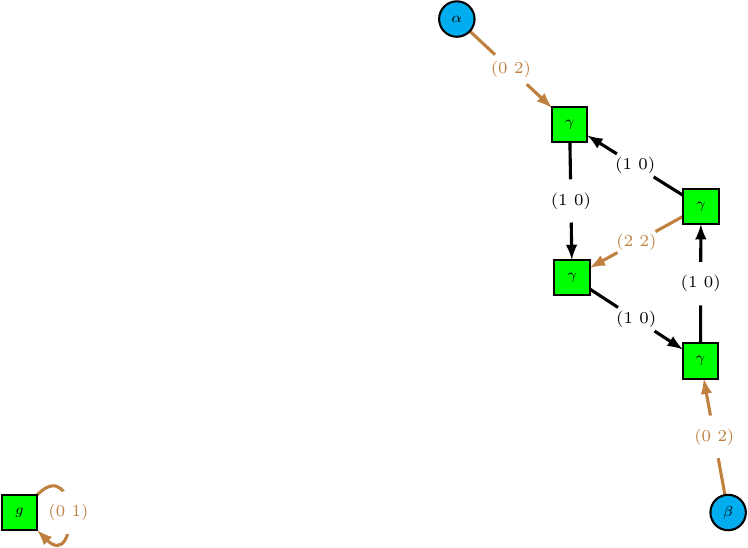

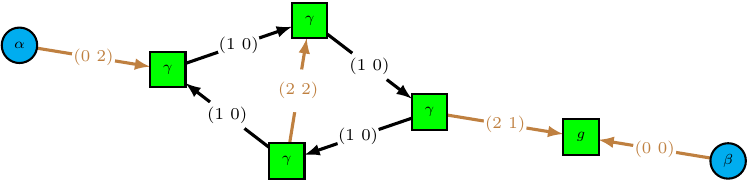

Output()

In [32]:
T.plot(size=14, edge_length=0.45)

L'algorithme tente également d'orienter le graphe de manière à minimiser l'espace vertical. Ce qui conduit en générale à des résultats assez prévisibles.

In [33]:
TF(g(mu, nu)+dirac_gamma(alpha, beta, mu)*dirac_gamma(beta, alpha, nu)+eps(mu, nu, rho, rho))

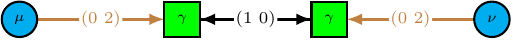

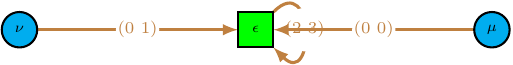

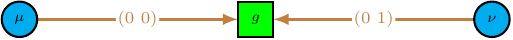

Output()

In [34]:
_.plot()

## Reste à faire

En plus des 19 TODO déjà présents plus haut :

- Nettoyer le code.  
- Modifier le code pour l'ajouter aux sources, pas juste un notebook.  
- Prédéfinir un certain nombre de ``tensor_field`` (Clifford, SU(N), Minkowski).  
- Implémenter un produit tensoriel entre ``tensor_field``.  
- Permettre l'ajouts de tenseurs après l'initialisation.  
- Conjugaison, transposée, adjoint, trace  
- Implémenter les opérations de dérivation (nouveau type de noeud et d'arête ?).  
- Dérivation fonctionnelle par rapport à l'un des tenseur de base.  
- Trouver quelque chose d'utile à faire à partir des relations de commutation  
- Et plein d'autres choses encore...  

